# Vision-Language Attention Analysis Experiments

In [1]:
!nvidia-smi

import sys
sys.path.append('../..')

import random
import pickle
from pathlib import Path

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

from dataset_zoo.aro_datasets import (get_controlled_images_b, get_controlled_images_a, COCO_QA_one_obj, COCO_QA_two_obj)
from mechanistic.utils.visualization import (
    plot_attention_heatmap, 
    plot_attention_on_image,
    plot_cross_attention_attribution
)
from mechanistic.utils.hooks import AttentionCache
from mechanistic.utils.metrics import attention_entropy, attention_concentration

%matplotlib inline
%load_ext autoreload
%autoreload 2

Mon Oct 27 18:37:00 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM-64GB           On  | 00000000:C8:00.0 Off |                    0 |
| N/A   44C    P0              63W / 460W |      2MiB / 65536MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
# Model path (update if needed)
model_path = "/leonardo_work/EUHPC_D27_102/compmech/models/Qwen3-VL-4B-Instruct"

print(f"Loading Qwen3-VL from: {model_path}")

# Load model
model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_path,
    dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="eager"
    # output_attentions=True  # This needs to be set during forward pass
)

# Load processor
processor = AutoProcessor.from_pretrained(model_path)

print(f"Model loaded successfully")
print(f"Device: {model.device}")

Loading Qwen3-VL from: /leonardo_work/EUHPC_D27_102/compmech/models/Qwen3-VL-4B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully
Device: cuda:0


In [3]:
model

Qwen3VLForConditionalGeneration(
  (model): Qwen3VLModel(
    (visual): Qwen3VLVisionModel(
      (patch_embed): Qwen3VLVisionPatchEmbed(
        (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (pos_embed): Embedding(2304, 1024)
      (rotary_pos_emb): Qwen3VLVisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-23): 24 x Qwen3VLVisionBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Qwen3VLVisionAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (mlp): Qwen3VLVisionMLP(
            (linear_fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (linear_fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (act_fn): GELUTanh()
          )
        )
      )
 

In [4]:
# Load dataset
dataset = get_controlled_images_b(
image_preprocess=None,
download=False,
root_dir='/leonardo_work/EUHPC_D27_102/compmech/whatsup_vlms_data'
)

print(f"Dataset size: {len(dataset)}")

# Define spatial relations to sample
spatial_relations = ['left', 'right', 'front', 'behind']
samples_per_relation = 2

# Find indices for each spatial relation
samples = {}
sampled_indices = [54, 37, 92, 334, 128, 286, 135, 193] # fixed experiments
if sampled_indices is None:
    for relation in spatial_relations:
        # Find all samples with this spatial relation
        relation_indices = []
        for idx in range(len(dataset)):
            caption = dataset[idx]['caption_options'][0]
            if relation in caption.lower().split():
                relation_indices.append(idx)
        
        print(f"Found {len(relation_indices)} samples for '{relation}'")
    
        # Sample 2 random examples for this relation
        sampled_indices = random.sample(relation_indices, samples_per_relation)
    
        # Add to samples dict
        for idx in sampled_indices:
            samples[idx] = dataset[idx]
else:
    for idx in sampled_indices:
        samples[idx] = dataset[idx]

print(f"\nTotal samples to process: {len(samples)}")

spatial_keywords = {'left', 'right', 'front', 'behind', 'under', 'above', 'below', 'on'}

# Process each sample
outputs_to_save = []
for dataset_idx, sample in samples.items():
    print(f"\n{'='*50}")
    print(f"SAMPLE - Dataset Index: {dataset_idx}")
    print(f"{'='*50}")
    
    # Extract caption and objects
    caption = sample['caption_options'][0]
    words = caption.split()
    object1 = words[1]  # Second word
    object2 = words[-1]  # Last word
    
    correct_answer = None
    for w in words:
        if w in spatial_keywords:
            correct_answer = w
    
    # Get image
    image = sample['image_options'][0]
    
    # Create question
    question = f"Where is the {object1} in relation to the {object2}? Answer with left, right, front or behind."
    print(f"Caption: {caption}")
    print(f"Object 1: {object1}")
    print(f"Object 2: {object2}")
    print(f"Question: {question}")
    print(f"Spatial relation: {correct_answer}")
    
    # Prepare messages in Qwen format
    messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question},
        ],
    }
    ]
    
    # Apply chat template
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
    )
    print(f"\nFormatted prompt (first 200 chars):\n{text[:200]}...")
    
    # Process inputs
    inputs = processor(
    text=[text],
    images=[image],
    padding=True,
    return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    
    print(f"Input shape: {inputs['input_ids'].shape}")
    print(f"Total tokens: {inputs['input_ids'].shape[1]}")
    
    # Forward pass with attention
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=10,  # Adjust as needed for single-word answers
            do_sample=False,  # Use greedy decoding for deterministic results
            return_dict_in_generate=True,
            output_attentions=True,
            output_hidden_states=True,
            output_logits=True,
            output_scores=True,
        )
    
        # Decode only the generated part (skip input tokens)
        input_length = inputs['input_ids'].shape[1]
        generated_text = processor.batch_decode(
          generated_ids['sequences'][:, input_length:],
          skip_special_tokens=True,
          clean_up_tokenization_spaces=False
        )[0].strip()
    
        model_answer = generated_text.split()[0] if generated_text else ""  # Get first word
        if model_answer.lower() != correct_answer.lower():
            raise ValueError(f"Model prediction '{model_answer}' does not match gold label '{correct_answer}'")
        print(model_answer)
        print(correct_answer)
        print(caption)
    
        print(f"Output keys: {generated_ids.keys()}")
    
    # Move outputs to CPU and prepare for saving
    sample_data = {
        'dataset_idx': dataset_idx,
        'image': image,
        'caption': caption,
        'object1': object1,
        'object2': object2,
        'question': question,
        'pred': model_answer,
        'GT': correct_answer,
        'input_ids': inputs['input_ids'].cpu(),
        #'attention_mask': inputs['attention_mask'].float().cpu(),
        'logits': tuple(l.float().cpu() for l in generated_ids['logits']),
        'attentions': tuple(
            tuple(attn.cpu() for attn in step) 
            for step in generated_ids['attentions']
        ),
        'hidden_states': tuple(
            tuple(h.cpu() for h in step)
            for step in generated_ids['hidden_states']
        ),
    }
    
    
    outputs_to_save.append(sample_data)

# # # Save to disk
# # output_dir = Path('/leonardo_work/EUHPC_D27_102/spatialmech/attn_patterns/')
# # output_dir.mkdir(exist_ok=True)

# # # Save as pickle
# # output_path = output_dir / 'sample_controlled_b.pkl'
# # with open(output_path, 'wb') as f:
# #   pickle.dump(outputs_to_save, f)
# # print(f"\nSaved {len(outputs_to_save)} samples to {output_path}")

# # # Print summary
# # print("\n" + "="*50)
# # print("SUMMARY")
# # print("="*50)

# # # Group by spatial relation
# # from collections import defaultdict
# # by_relation = defaultdict(list)
# # for data in outputs_to_save:
# #   by_relation[data['GT']].append(data['dataset_idx'])

# # for relation in spatial_relations:
# #   print(f"\n{relation.upper()}:")
# #   if relation in by_relation:
# #       for idx in by_relation[relation]:
# #           data = next(d for d in outputs_to_save if d['dataset_idx'] == idx)
# #           print(f"  - Index {idx}: {data['question']}")
# #           print(f"    Logits shape: {data['logits'].shape}")
# #           print(f"    Num attention layers: {len(data['attentions'])}")

Dataset size: 408

Total samples to process: 8

SAMPLE - Dataset Index: 54
Caption: A mug to the left of a book
Object 1: mug
Object 2: book
Question: Where is the mug in relation to the book? Answer with left, right, front or behind.
Spatial relation: left


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Formatted prompt (first 200 chars):
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Where is the mug in relation to the book? Answer with left, right, front or behind.<|im_end|>
<|im_start|>assistant
...
Input shape: torch.Size([1, 1230])
Total tokens: 1230
left
left
A mug to the left of a book
Output keys: odict_keys(['sequences', 'scores', 'logits', 'attentions', 'hidden_states', 'past_key_values'])

SAMPLE - Dataset Index: 37
Caption: A bowl to the left of a cup
Object 1: bowl
Object 2: cup
Question: Where is the bowl in relation to the cup? Answer with left, right, front or behind.
Spatial relation: left

Formatted prompt (first 200 chars):
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Where is the bowl in relation to the cup? Answer with left, right, front or behind.<|im_end|>
<|im_start|>assistant
...
Input shape: torch.Size([1, 1230])
Total tokens: 1230
left
left
A bowl to the left of a cup
Output keys: odict_keys(['sequences', 'scores', 'logits', 'att

## Attention Experiments

In [5]:
# Select sample to analyze (change this to analyze different samples)
sample_idx = 0
sample = outputs_to_save[sample_idx]

token_ids = sample['input_ids'][0]
seq_len = len(token_ids)
tokens_list = [processor.tokenizer.decode(t) for t in outputs_to_save[0]['input_ids'][0]]

# Find special vision tokens
vision_start_token = "<|vision_start|>"
vision_end_token = "<|vision_end|>"

vision_start_idx = None
vision_end_idx = None

for i, token in enumerate(tokens_list):
    if vision_start_token in token:
        vision_start_idx = i
    if vision_end_token in token:
        vision_end_idx = i
        break

# Define token ranges
image_start_idx = vision_start_idx + 1  # Skip <|vision_start|>
image_end_idx = vision_end_idx          # Before <|vision_end|>
text_start_idx = vision_end_idx + 1     # After <|vision_end|>
text_end_idx = seq_len

num_image_tokens = image_end_idx - image_start_idx
num_text_tokens = text_end_idx - text_start_idx

# Calculate image grid size (assuming square patches)
grid_size = int(np.sqrt(num_image_tokens))

text_tokens = tokens_list[text_start_idx: text_end_idx]

print("\n" + "="*80)
print("TOKEN BOUNDARIES")
print("="*80)
print(f"Vision start token at: {vision_start_idx}")
print(f"Vision end token at: {vision_end_idx}")
print(f"\nImage tokens: [{image_start_idx}, {image_end_idx}) = {num_image_tokens} tokens")
print(f"Image grid size: {grid_size} x {grid_size}")
print(f"\nText tokens: [{text_start_idx}, {text_end_idx}) = {num_text_tokens} tokens")
print(f"\nDecoded text tokens:")
print(text_tokens)


TOKEN BOUNDARIES
Vision start token at: 3
Vision end token at: 1204

Image tokens: [4, 1204) = 1200 tokens
Image grid size: 34 x 34

Text tokens: [1205, 1230) = 25 tokens

Decoded text tokens:
['Where', ' is', ' the', ' mug', ' in', ' relation', ' to', ' the', ' book', '?', ' Answer', ' with', ' left', ',', ' right', ',', ' front', ' or', ' behind', '.', '<|im_end|>', '\n', '<|im_start|>', 'assistant', '\n']


## Logit Lens

In [6]:
import torch.nn.functional as F

candidate_words = ["left", "right", "front", "behind"]
candidate_ids = [processor.tokenizer.encode(w, add_special_tokens=False)[0]
                 for w in candidate_words]

hidden_states = sample["hidden_states"][0]  # [batch, seq_len, d_model] 0: first output token

# choose where to read the logits from // last token
target_pos = sample["input_ids"][0].shape[0] - 1

# Prepare storage
layer_logits = []

with torch.no_grad():
    # apply lm_head to project into vocab space
    for layer_idx, h in enumerate(hidden_states):
        vec = h[0, target_pos]     # [d_model]
        lm = model.lm_head if hasattr(model, "lm_head") else model.get_output_embeddings()
        logits = lm(vec.to("cuda"))        # [vocab_size]
        # restrict to candidates
        #cand_logits = logits[candidate_ids]
        layer_logits.append(logits.detach().float().cpu().numpy())

layer_logits = np.stack(layer_logits)  # [num_layers, num_candidates]
layer_probs = F.softmax(torch.tensor(layer_logits), dim=1).numpy()

In [7]:
correct_label = sample["GT"]
correct_idx = candidate_words.index(correct_label)

p_correct = layer_probs[:, correct_idx]
logit_gap = layer_logits[:, correct_idx] - np.max(
    np.delete(layer_logits, correct_idx, axis=1), axis=1
)
first_layer_correct = np.where(p_correct == np.max(p_correct))[0][0]

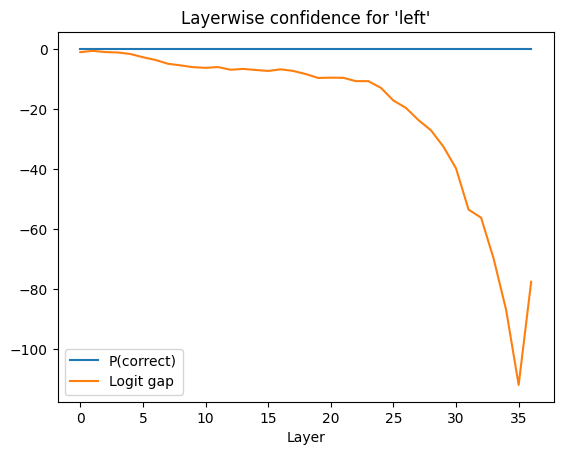

In [8]:
import matplotlib.pyplot as plt
plt.plot(p_correct, label='P(correct)')
plt.plot(logit_gap, label='Logit gap')
plt.xlabel('Layer')
plt.legend()
plt.title(f"Layerwise confidence for '{correct_label}'")
plt.show()

In [9]:
num_layers, vocab_size = layer_probs.shape
top_n = 3
# Collect textual top-n outputs
layer_results = []
for layer_idx in range(num_layers):
    logits = layer_probs[layer_idx]
    top_indices = np.argsort(logits)[-top_n:][::-1]  # top-n sorted descending
    top_probs = logits[top_indices]
    top_tokens = [processor.tokenizer.decode([i], add_special_tokens=False) for i in top_indices]
    layer_results.append((layer_idx, list(zip(top_tokens, top_probs))))

# Display text summary
print(sample['caption'])
for layer_idx, pairs in layer_results:
    formatted = "| ".join([f"{repr(tok)} ({p:.3f})" for tok, p in pairs])
    print(f"Layer {layer_idx:02d}: {formatted}")

A mug to the left of a book
Layer 00: '\n' (0.000)| ' ' (0.000)| '\n\n' (0.000)
Layer 01: ' dign' (0.000)| '();\r\n\r\n\r\n' (0.000)| '各区' (0.000)
Layer 02: '();\r\n\r\n\r\n' (0.000)| '<>("' (0.000)| ' 답' (0.000)
Layer 03: '();\r\n\r\n\r\n' (0.000)| ' 답' (0.000)| ' ölçü' (0.000)
Layer 04: '();\r\n\r\n\r\n' (0.000)| '};\r\n\r\n\r\n' (0.000)| 'йт' (0.000)
Layer 05: '();\r\n\r\n\r\n' (0.000)| ' firefight' (0.000)| '};\r\n\r\n\r\n' (0.000)
Layer 06: '();\r\n\r\n\r\n' (0.000)| ' firefight' (0.000)| '\t\r\n\r\n' (0.000)
Layer 07: '();\r\n\r\n\r\n' (0.000)| ' firefight' (0.000)| '};\r\n\r\n\r\n' (0.000)
Layer 08: '();\r\n\r\n\r\n' (0.000)| '};\r\n\r\n\r\n' (0.000)| 'toMatchSnapshot' (0.000)
Layer 09: '();\r\n\r\n\r\n' (0.000)| '};\r\n\r\n\r\n' (0.000)| ' intrig' (0.000)
Layer 10: '};\r\n\r\n\r\n' (0.000)| '();\r\n\r\n\r\n' (0.000)| '}\r\n\r\n\r\n\r\n' (0.000)
Layer 11: '};\r\n\r\n\r\n' (0.000)| '();\r\n\r\n\r\n' (0.000)| ' tér' (0.000)
Layer 12: '};\r\n\r\n\r\n' (0.000)| '();\r\n\r\n\r\n' (0.

In [10]:
attentions = sample["attentions"][0] # first generation step

num_layers = len(attentions)
num_heads = attentions[0].shape[1]
seq_len = attentions[0].shape[-1]

last_token_idx = seq_len - 1  # last token (query position)

layerwise_attn = []
for layer_idx, attn in enumerate(attentions):
    # attn: [1, num_heads, seq_len, seq_len]
    avg = attn[0].mean(dim=0)  # average across heads → [seq_len, seq_len]
    last_token_attn = avg[last_token_idx]  # attention distribution for last token → [seq_len]
    layerwise_attn.append(last_token_attn.float().cpu().numpy())

layerwise_attn = np.stack(layerwise_attn)  # [num_layers, seq_len]

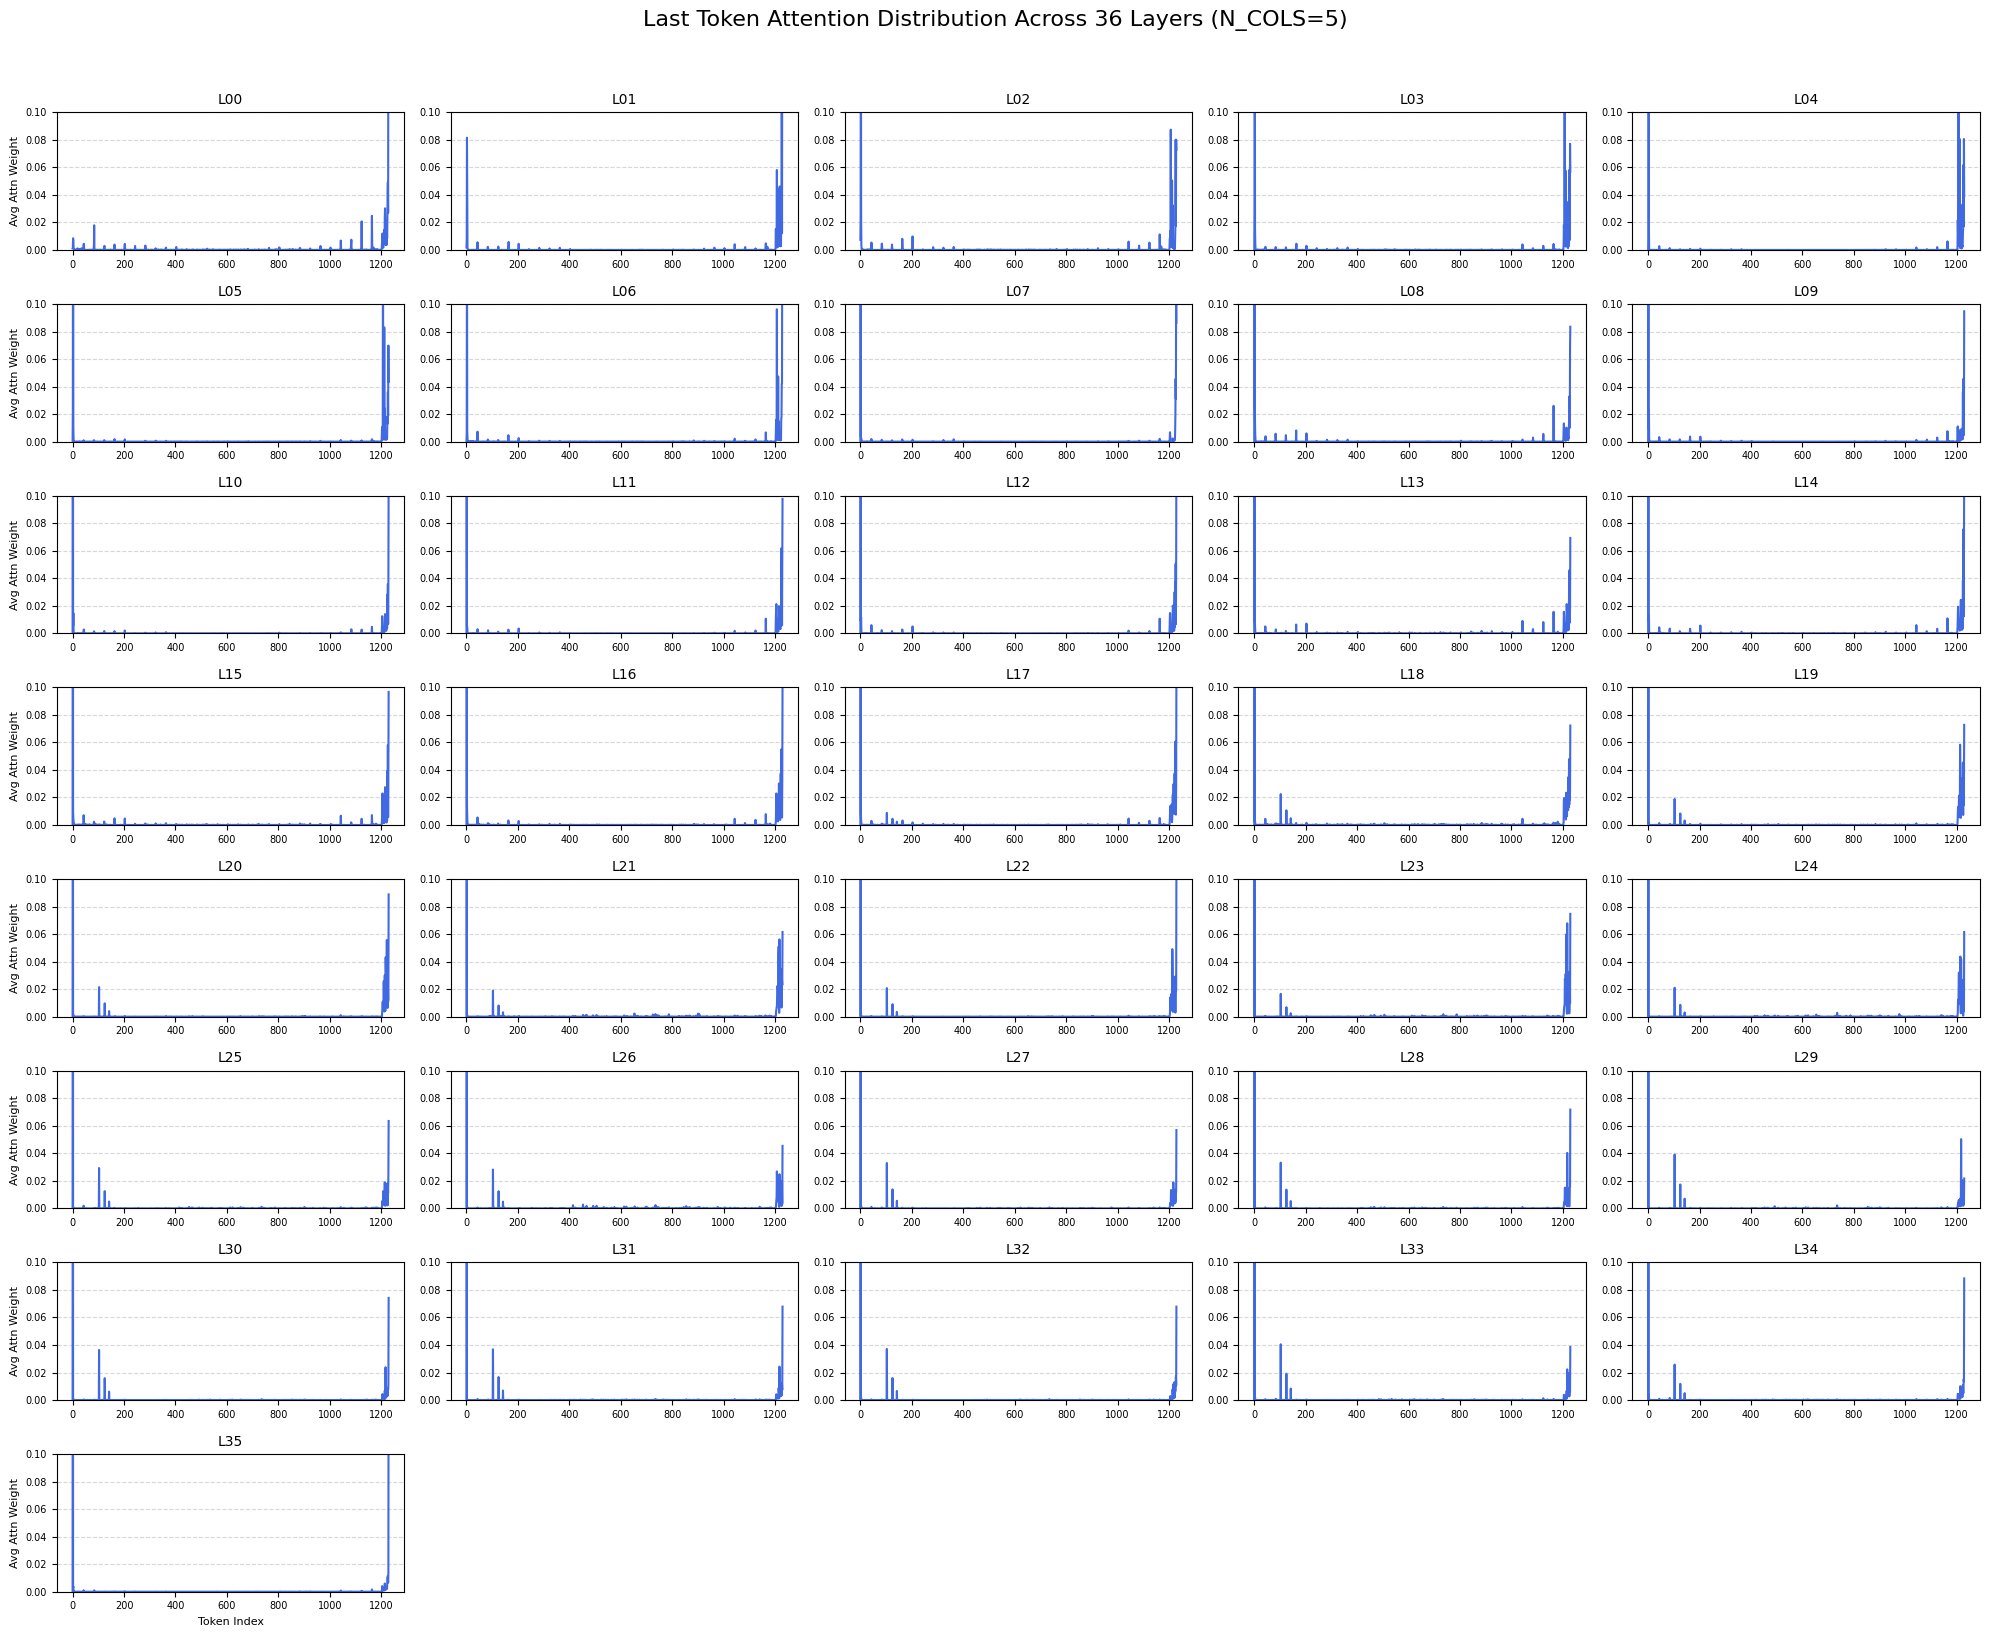

In [11]:
import math

# --- User Input/Configuration ---
# Define how many columns you want in the subplot grid
N_COLS = 5 

# Get dimensions (assuming layerwise_attn is already populated)
num_layers = layerwise_attn.shape[0]
seq_len = layerwise_attn.shape[1]

# Calculate the required number of rows
n_rows = math.ceil(num_layers / N_COLS)

# Create the figure and the grid of subplots (axes)
# Set a suitable figure size based on the number of rows and columns
fig, axes = plt.subplots(n_rows, N_COLS, figsize=(4 * N_COLS, 2 * n_rows), squeeze=False)

# Determine the global Y-limit to keep the scale consistent across all plots
# Using the user's previously set limit (0.1) or calculating the max value
Y_LIMIT = 0.1 # max(layerwise_attn.max() * 1.1, 0.1) 

fig.suptitle(
    f"Last Token Attention Distribution Across {num_layers} Layers (N_COLS={N_COLS})", 
    fontsize=16, 
    y=1.02 # Raise title slightly above the subplots
)

# Flatten the axes array for easy indexing, especially when n_rows=1
axes = axes.flatten()

# Iterate through all layers
for layer_idx in range(num_layers):
    attention_distribution = layerwise_attn[layer_idx]
    
    # Get the specific axis for the current layer
    ax = axes[layer_idx]
    
    # Plot the attention distribution
    ax.plot(range(seq_len), attention_distribution, linewidth=1.5, color='royalblue')
    
    # Set plot properties
    ax.set_title(f"L{layer_idx:02d}", fontsize=10)
    ax.set_ylim(0, Y_LIMIT) # Enforce consistent vertical scale
    
    # Only show the X-label and Y-label on the bottom row and leftmost column
    if layer_idx % N_COLS == 0:
        ax.set_ylabel("Avg Attn Weight", fontsize=8)
    if layer_idx >= (n_rows - 1) * N_COLS:
        ax.set_xlabel("Token Index", fontsize=8)

    # Clean up ticks and labels for better visualization
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
# Hide any unused subplots (if num_layers is not a perfect multiple of N_COLS)
for i in range(num_layers, n_rows * N_COLS):
    fig.delaxes(axes[i])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [12]:
topk = 10
for layer_idx in range(17,len(layerwise_attn)):
    attn = layerwise_attn[layer_idx]
    top_indices = np.argsort(attn)[-topk:][::-1]
    top_tokens = [tokens_list[i].strip() for i in top_indices]
    top_values = attn[top_indices]

    print(f"\nLayer {layer_idx}: Top-{topk} attended tokens")
    for tok, val, idx in zip(top_tokens, top_values, top_indices):
        print(f"  idx={idx:>4} | attn={val:.3f} | token='{tok}'")


Layer 17: Top-10 attended tokens
  idx=   1 | attn=0.355 | token='user'
  idx=1229 | attn=0.111 | token=''
  idx=1224 | attn=0.061 | token='.'
  idx=1226 | attn=0.054 | token=''
  idx=1222 | attn=0.037 | token='or'
  idx=1218 | attn=0.030 | token=','
  idx=1228 | attn=0.027 | token='assistant'
  idx=1215 | attn=0.022 | token='Answer'
  idx=1217 | attn=0.015 | token='left'
  idx=1210 | attn=0.015 | token='relation'

Layer 18: Top-10 attended tokens
  idx=   1 | attn=0.295 | token='user'
  idx=1229 | attn=0.072 | token=''
  idx=1224 | attn=0.048 | token='.'
  idx=1226 | attn=0.044 | token=''
  idx=1222 | attn=0.035 | token='or'
  idx=1228 | attn=0.024 | token='assistant'
  idx=1213 | attn=0.023 | token='book'
  idx=1218 | attn=0.023 | token=','
  idx= 103 | attn=0.022 | token='<|image_pad|>'
  idx=1214 | attn=0.021 | token='?'

Layer 19: Top-10 attended tokens
  idx=   1 | attn=0.340 | token='user'
  idx=1229 | attn=0.073 | token=''
  idx=1213 | attn=0.058 | token='book'
  idx=1224 | at

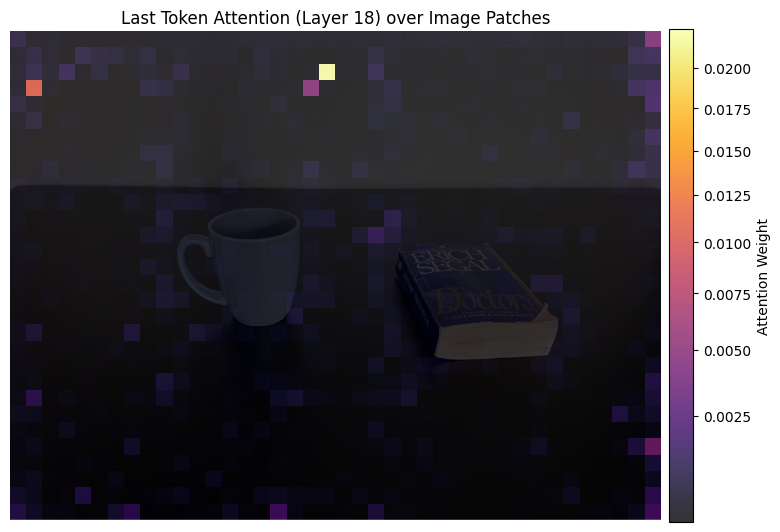

In [13]:
from matplotlib.colors import PowerNorm
IMG_WIDTH, IMG_HEIGHT = sample['image'].size
patch_size = 32
GRID_H = IMG_HEIGHT // patch_size
GRID_W = IMG_WIDTH // patch_size
num_image_tokens = GRID_H * GRID_W # 1200

layer_idx = 18
last_token_attention_vector = layerwise_attn[layer_idx]
img_attn = last_token_attention_vector[image_start_idx : image_end_idx]

assert num_image_tokens == len(img_attn)

img_grid = img_attn.reshape(GRID_H, GRID_W) # Reshape to 30 x 40
extent = (0, IMG_WIDTH, IMG_HEIGHT, 0)

plt.figure(figsize=(10, 8))
plt.imshow(sample['image']) 

plt.imshow(
    img_grid, 
    cmap="inferno", 
    alpha=0.8,
    extent=extent,
    interpolation='nearest',
    norm=PowerNorm(gamma=0.7)
)
plt.title(f"Last Token Attention (Layer {layer_idx}) over Image Patches")
plt.colorbar(label='Attention Weight', orientation='vertical', shrink=0.8, pad=0.01,)
plt.axis("off")
plt.show()

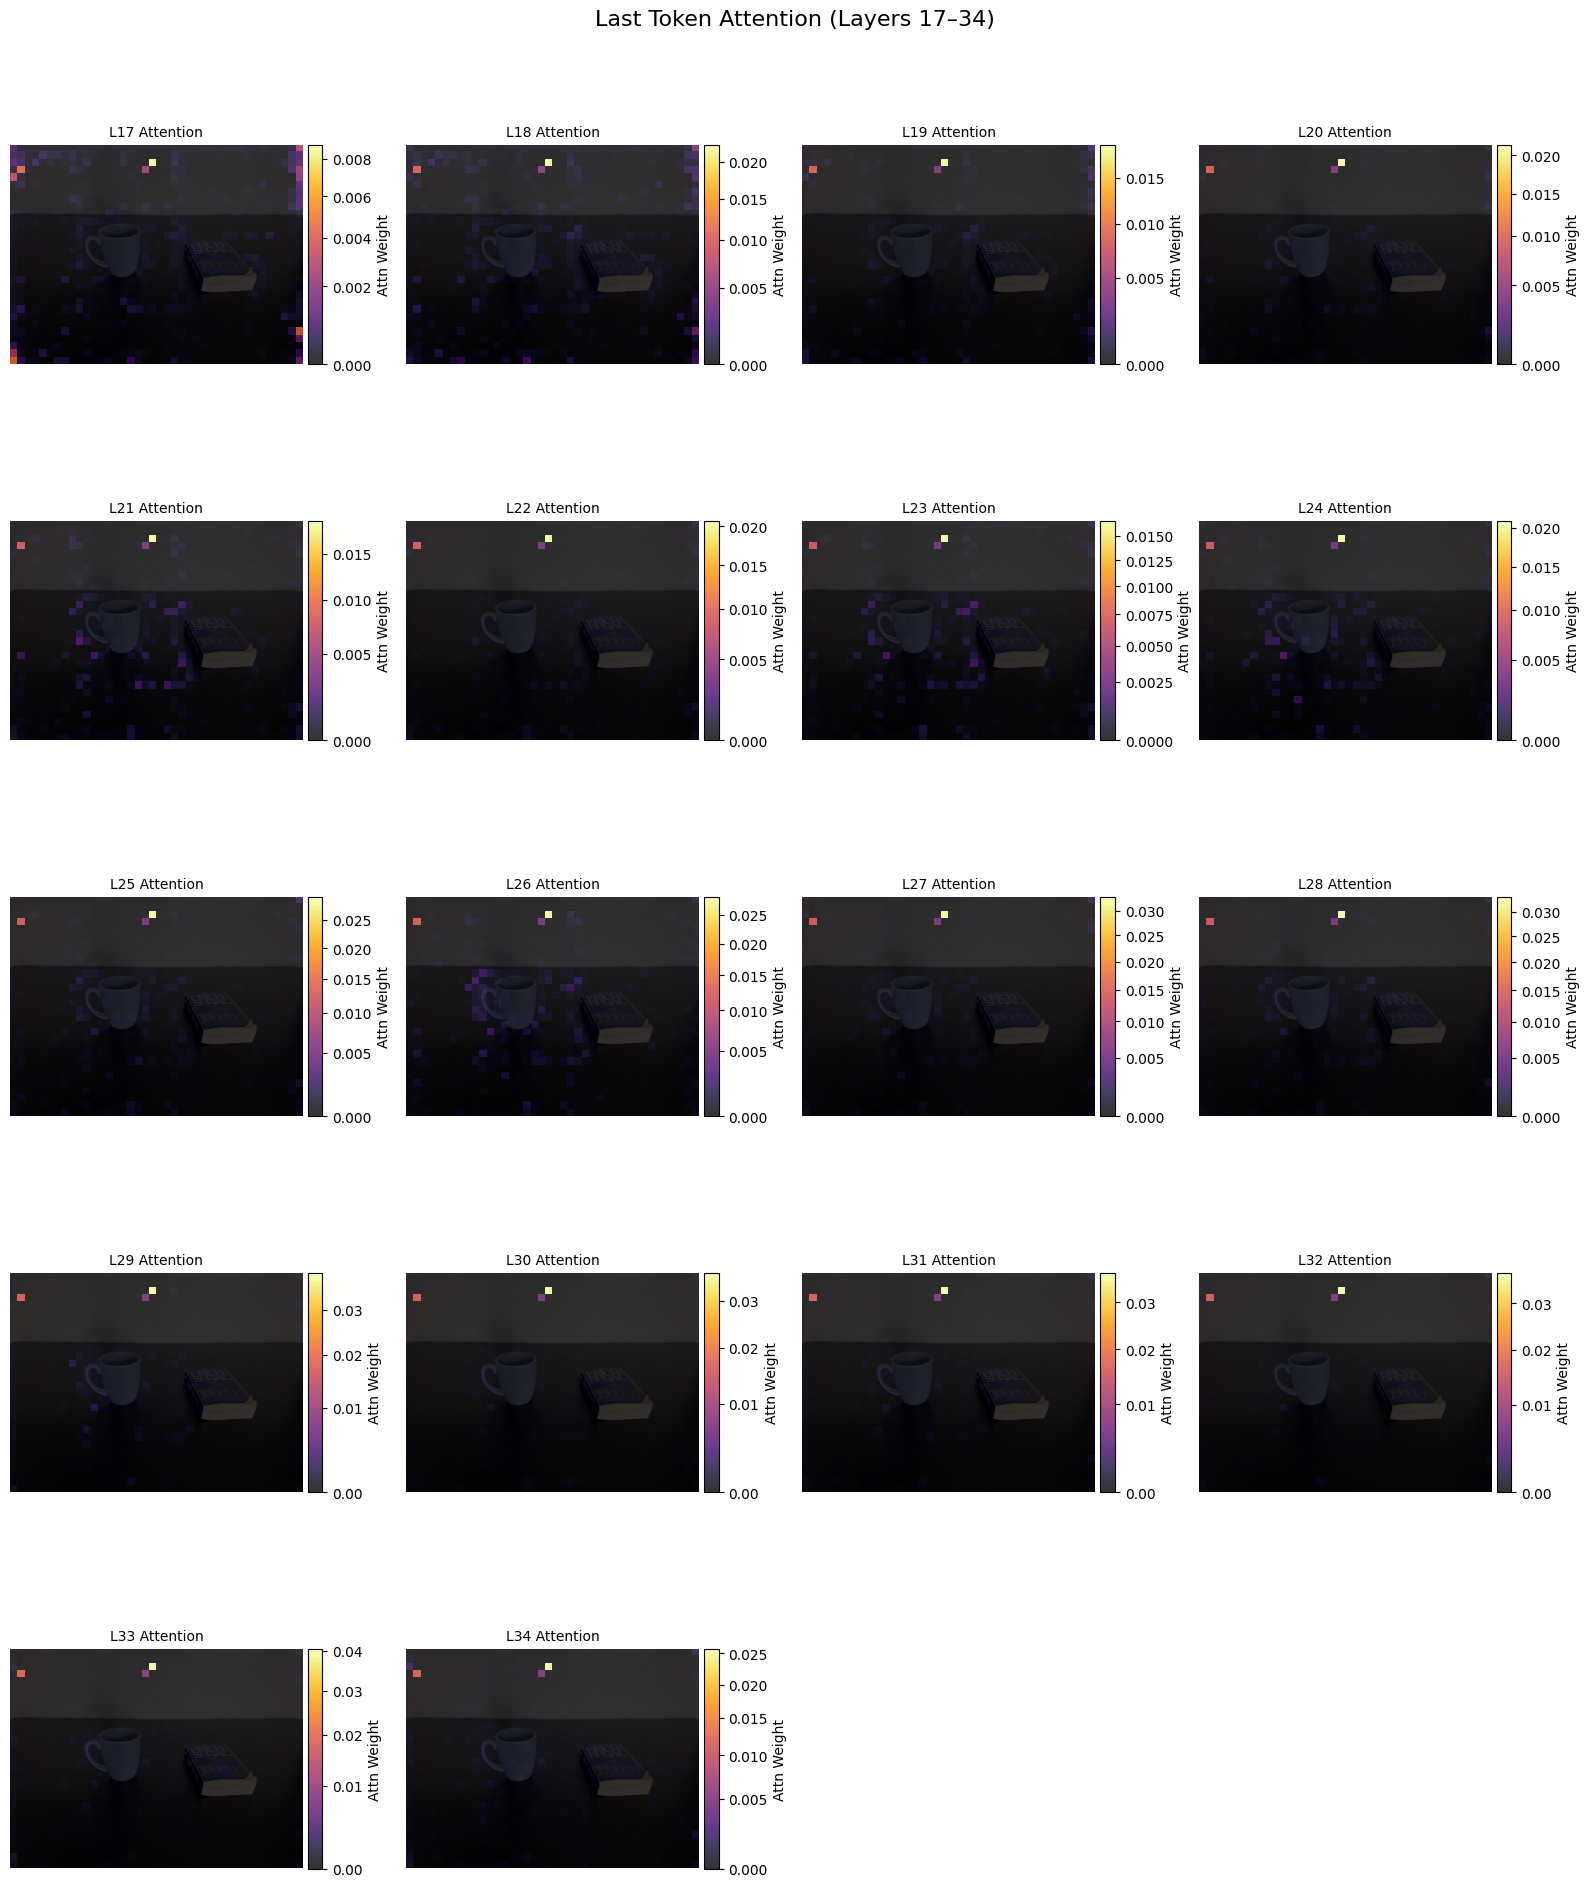

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable # Tool to help with colorbar placement

# --- 1. Configuration and Constants ---
N_COLS = 4
# Define the range of layers to plot (e.g., layers 0 through 23, adjust as needed)
LAYER_START = 17
LAYER_END = 35 # Plots up to, but not including, this layer index
LAYER_RANGE = range(LAYER_START, LAYER_END) 

# Image and Grid Dimensions (assuming these are constant from your code)
IMG_WIDTH, IMG_HEIGHT = sample['image'].size
patch_size = 32
GRID_H = IMG_HEIGHT // patch_size
GRID_W = IMG_WIDTH // patch_size
num_image_tokens = GRID_H * GRID_W
extent = (0, IMG_WIDTH, IMG_HEIGHT, 0)

# --- 2. Subplot Setup ---
num_layers_to_plot = len(LAYER_RANGE)
n_rows = math.ceil(num_layers_to_plot / N_COLS)

# Create figure and subplots. Adjust figsize based on the number of plots.
fig, axes = plt.subplots(n_rows, N_COLS, 
                         figsize=(4 * N_COLS, 4 * n_rows), 
                         squeeze=False)
axes = axes.flatten() # Flatten the 2D array of axes for easy indexing

# --- 3. Plotting Loop ---
for plot_idx, layer_idx in enumerate(LAYER_RANGE):
    
    # A. Data Extraction and Reshaping
    last_token_attention_vector = layerwise_attn[layer_idx]
    img_attn = last_token_attention_vector[image_start_idx : image_end_idx]
    
    # Safety Check
    if len(img_attn) != num_image_tokens:
        print(f"Skipping layer {layer_idx}: token count mismatch.")
        continue
        
    img_grid = img_attn.reshape(GRID_H, GRID_W)
    
    # B. Select the current axis
    ax = axes[plot_idx]
    
    # C. Plot the Image (Background)
    ax.imshow(sample['image'])
    
    # D. Plot the Attention Heatmap (Overlay)
    # Using the PowerNorm with gamma=0.7 as specified
    img_plot = ax.imshow(
        img_grid,
        cmap="inferno",
        alpha=0.8,
        extent=extent,
        interpolation='nearest',
        norm=PowerNorm(gamma=0.7, vmin=0) # Vmin=0 is important for PowerNorm
    )
    
    # E. Tidy up the plot
    ax.set_title(f"L{layer_idx:02d} Attention", fontsize=10)
    ax.axis("off")

    # F. Add Colorbar (Crucial for subplots)
    # We use make_axes_locatable to create a new axis specifically for the colorbar, 
    # positioned neatly next to the subplot.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05) # Pad controls space
    
    fig.colorbar(
        img_plot, 
        cax=cax, 
        orientation='vertical',
        label='Attn Weight'
    )

# --- 4. Final Touches ---
# Hide any unused subplots
for i in range(num_layers_to_plot, n_rows * N_COLS):
    fig.delaxes(axes[i])

fig.suptitle(f"Last Token Attention (Layers {LAYER_START}–{LAYER_END-1})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust tight_layout to account for suptitle
plt.show()

In [15]:
# other analysis
attentions = sample["attentions"][0] # first generation step

num_layers = len(attentions)
num_heads = attentions[0].shape[1]
seq_len = attentions[0].shape[-1]

# select a specific token
TARGET_WORD = 'book'
for i, token in enumerate(tokens_list):
    if TARGET_WORD in token.strip(): # Use .strip() for robust matching
        query_token_idx = i
        break

layerwise_attn = []
for layer_idx, attn in enumerate(attentions):
    avg = attn[0].mean(dim=0)  
    query_token_attn = avg[query_token_idx]
    layerwise_attn.append(query_token_attn.float().cpu().numpy())
layerwise_attn = np.stack(layerwise_attn)  # [num_layers, seq_len]

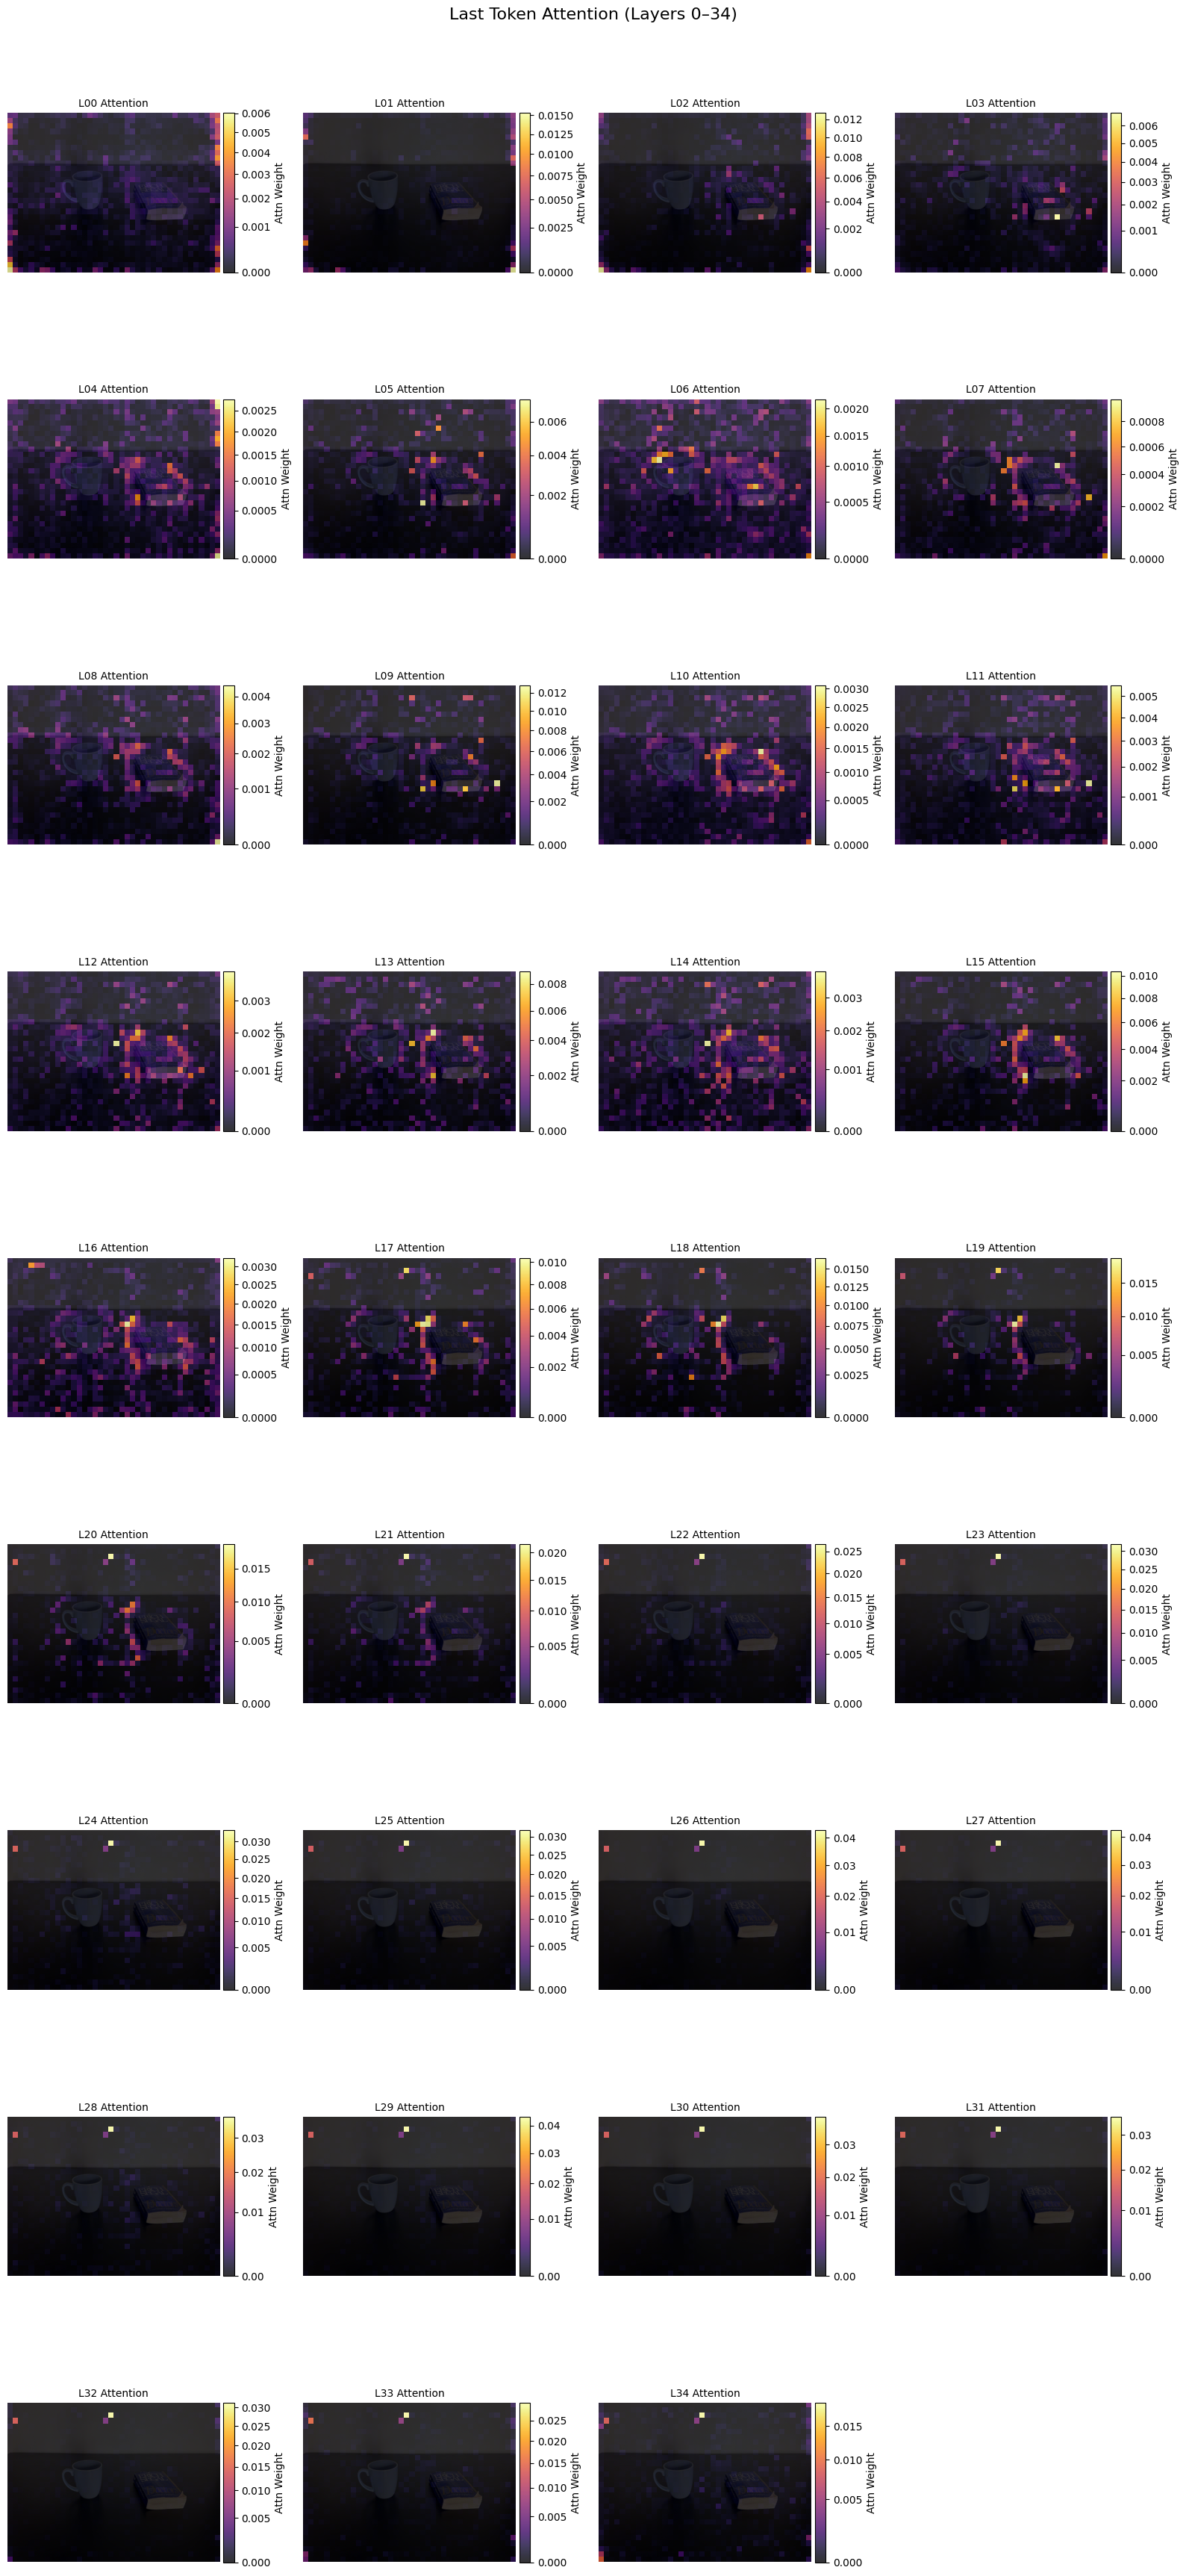

In [16]:
N_COLS = 4
# Define the range of layers to plot (e.g., layers 0 through 23, adjust as needed)
LAYER_START = 0
LAYER_END = 35 # Plots up to, but not including, this layer index
LAYER_RANGE = range(LAYER_START, LAYER_END) 

# Image and Grid Dimensions (assuming these are constant from your code)
IMG_WIDTH, IMG_HEIGHT = sample['image'].size
patch_size = 32
GRID_H = IMG_HEIGHT // patch_size
GRID_W = IMG_WIDTH // patch_size
num_image_tokens = GRID_H * GRID_W
extent = (0, IMG_WIDTH, IMG_HEIGHT, 0)

num_layers_to_plot = len(LAYER_RANGE)
n_rows = math.ceil(num_layers_to_plot / N_COLS)

# Create figure and subplots. Adjust figsize based on the number of plots.
fig, axes = plt.subplots(n_rows, N_COLS, 
                         figsize=(4 * N_COLS, 4 * n_rows), 
                         squeeze=False)
axes = axes.flatten() # Flatten the 2D array of axes for easy indexing

for plot_idx, layer_idx in enumerate(LAYER_RANGE):
    
    # A. Data Extraction and Reshaping
    last_token_attention_vector = layerwise_attn[layer_idx]
    img_attn = last_token_attention_vector[image_start_idx : image_end_idx]
    
    # Safety Check
    if len(img_attn) != num_image_tokens:
        print(f"Skipping layer {layer_idx}: token count mismatch.")
        continue
        
    img_grid = img_attn.reshape(GRID_H, GRID_W)
    
    # B. Select the current axis
    ax = axes[plot_idx]
    
    # C. Plot the Image (Background)
    ax.imshow(sample['image'])
    
    # D. Plot the Attention Heatmap (Overlay)
    # Using the PowerNorm with gamma=0.7 as specified
    img_plot = ax.imshow(
        img_grid,
        cmap="inferno",
        alpha=0.8,
        extent=extent,
        interpolation='nearest',
        norm=PowerNorm(gamma=0.7, vmin=0) # Vmin=0 is important for PowerNorm
    )
    
    # E. Tidy up the plot
    ax.set_title(f"L{layer_idx:02d} Attention", fontsize=10)
    ax.axis("off")

    # F. Add Colorbar (Crucial for subplots)
    # We use make_axes_locatable to create a new axis specifically for the colorbar, 
    # positioned neatly next to the subplot.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05) # Pad controls space
    
    fig.colorbar(
        img_plot, 
        cax=cax, 
        orientation='vertical',
        label='Attn Weight'
    )

# Hide any unused subplots
for i in range(num_layers_to_plot, n_rows * N_COLS):
    fig.delaxes(axes[i])

fig.suptitle(f"Last Token Attention (Layers {LAYER_START}–{LAYER_END-1})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust tight_layout to account for suptitle
plt.show()

In [17]:
# logit lens into these top key image tokens
attention_to_image = layerwise_attn[:, image_start_idx:image_end_idx]
token_attention_sum = attention_to_image.sum(axis=0)
top_n_image_tokens = 3
# np.argsort sorts smallest to largest; [-top_n_image_tokens:][::-1] gets top-N descending
top_3_relative_indices = np.argsort(token_attention_sum)[-top_n_image_tokens:][::-1]
top_3_absolute_indices = top_3_relative_indices + image_start_idx
print("✅ Top 3 Image Tokens identified:")
print(f"Indices relative to image start: {top_3_relative_indices}")
print(f"Absolute Sequence Indices: {top_3_absolute_indices.tolist()}")

✅ Top 3 Image Tokens identified:
Indices relative to image start: [ 99 121 138]
Absolute Sequence Indices: [103, 125, 142]


In [18]:
import torch
import torch.nn.functional as F
import numpy as np

# --- Configuration (Assumed to be defined) ---
# top_3_absolute_indices: [idx1, idx2, idx3] (The sequence indices of the top image tokens)
# sample: Contains "hidden_states" (the tuple of layer outputs)
# model: Contains the output embedding layer (lm_head/get_output_embeddings)
# processor: Contains the tokenizer
# ---------------------------------------------

# Assuming TARGET_POSITIONS is defined from the previous step
TARGET_POSITIONS = top_3_absolute_indices.tolist()

# The hidden states are now accessed correctly as a tuple of tensors:
hidden_states_tuple = sample["hidden_states"][0] 
num_layers = len(hidden_states_tuple)

# Prepare dictionary to store results for each target position
all_layer_probs = {}


def run_logit_lens_analysis_corrected(target_pos_idx, hidden_states_tuple, model):
    """
    Runs logit lens for a single token position using the correct tuple structure
    for hidden_states.
    """
    
    layer_logits = []
    
    # Check if target_pos is valid
    # Assuming all layers have the same sequence length (h[0].shape[1])
    seq_len = hidden_states_tuple[0].shape[1]
    if target_pos_idx >= seq_len or target_pos_idx < 0:
        print(f"Error: Target position {target_pos_idx} is out of bounds for sequence length {seq_len}")
        return None

    lm_head = model.lm_head if hasattr(model, "lm_head") else model.get_output_embeddings()
    device = lm_head.weight.device

    with torch.no_grad():
        # Iterate directly over the hidden state tensor for each layer in the tuple
        for layer_idx, h_tensor in enumerate(hidden_states_tuple):
            # h_tensor shape: [batch, seq_len, d_model]
            
            # 1. Select the hidden state vector at the target position
            # h_tensor[0, target_pos_idx] -> [d_model]
            vec = h_tensor[0, target_pos_idx] 
            
            # 2. Apply the unembedding layer (lm_head)
            logits = lm_head(vec.to(device))  # [vocab_size]
            
            layer_logits.append(logits.detach().float().cpu().numpy())

    layer_logits_stack = np.stack(layer_logits)  # [num_layers, vocab_size]
    
    # 3. Calculate softmax probabilities
    layer_probs = F.softmax(torch.tensor(layer_logits_stack), dim=1).numpy()
    
    return layer_probs


# --- Run Analysis for Each Top Token ---
print(f"Starting Logit Lens for top image tokens: {TARGET_POSITIONS}")

for target_idx in TARGET_POSITIONS:
    print(f"\nAnalyzing token at sequence position: {target_idx}")
    
    # Pass the correct hidden_states_tuple and model object
    probs = run_logit_lens_analysis_corrected(target_idx, hidden_states_tuple, model)
    
    if probs is not None:
        all_layer_probs[target_idx] = probs
        
        # --- Display Logit Lens Summary ---
        top_n = 3
        num_layers, vocab_size = probs.shape
        
        print("Top Predictions:")
        for layer_idx in range(num_layers):
            top_indices = np.argsort(probs[layer_idx])[-top_n:][::-1]
            top_probs = probs[layer_idx][top_indices]
            
            # Decode the top token indices
            top_tokens = [processor.tokenizer.decode([i], add_special_tokens=False) for i in top_indices]
            
            formatted = "| ".join([f"{repr(tok)} ({p:.3f})" for tok, p in zip(top_tokens, top_probs)])
            print(f"Layer {layer_idx:02d}: {formatted}")

print("\n✅ Analysis complete with corrected hidden state access. Results stored in 'all_layer_probs'.")

Starting Logit Lens for top image tokens: [103, 125, 142]

Analyzing token at sequence position: 103
Top Predictions:
Layer 00: '微观' (0.000)| '平静' (0.000)| '现象' (0.000)
Layer 01: '消失了' (0.000)| 'soles' (0.000)| ' mø' (0.000)
Layer 02: '…”' (0.000)| '帙' (0.000)| 'øj' (0.000)
Layer 03: '…”' (0.000)| '();\r\n\r\n\r\n' (0.000)| ' medi' (0.000)
Layer 04: '();\r\n\r\n\r\n' (0.000)| '};\r\n\r\n\r\n' (0.000)| '…”' (0.000)
Layer 05: '();\r\n\r\n\r\n' (0.001)| '};\r\n\r\n\r\n' (0.000)| ' красот' (0.000)
Layer 06: '();\r\n\r\n\r\n' (0.001)| ' красот' (0.001)| 'cosa' (0.001)
Layer 07: 'cosa' (0.001)| '};\r\n\r\n\r\n' (0.001)| ' красот' (0.001)
Layer 08: 'cosa' (0.001)| '();\r\n\r\n\r\n' (0.001)| '};\r\n\r\n\r\n' (0.001)
Layer 09: 'cosa' (0.001)| '};\r\n\r\n\r\n' (0.001)| '();\r\n\r\n\r\n' (0.001)
Layer 10: 'cosa' (0.001)| '();\r\n\r\n\r\n' (0.000)| ' красот' (0.000)
Layer 11: 'cosa' (0.001)| '许久' (0.000)| ' cresc' (0.000)
Layer 12: 'cosa' (0.001)| '许久' (0.000)| ' cresc' (0.000)
Layer 13: 'cosa' (0

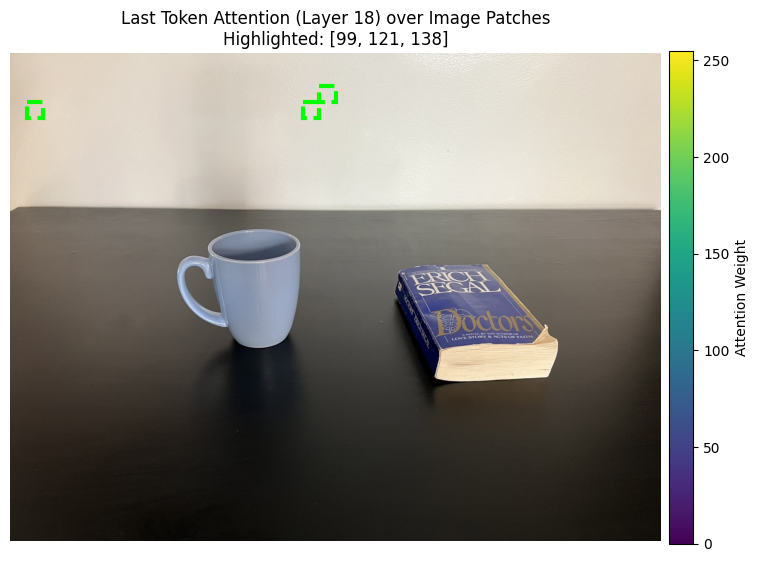

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import PowerNorm
from matplotlib.patches import Rectangle # Import for drawing rectangles

# --- Configuration (from previous steps) ---
IMG_WIDTH, IMG_HEIGHT = sample['image'].size
patch_size = 32
GRID_H = IMG_HEIGHT // patch_size
GRID_W = IMG_WIDTH // patch_size
num_image_tokens = GRID_H * GRID_W # 1200

# --- Specific Layer and Attention Data ---
layer_idx = 18 # The layer you are currently plotting
last_token_attention_vector = layerwise_attn[layer_idx]
img_attn = last_token_attention_vector[image_start_idx : image_end_idx]

assert num_image_tokens == len(img_attn)

img_grid = img_attn.reshape(GRID_H, GRID_W) # Reshape to 30 x 40
extent = (0, IMG_WIDTH, IMG_HEIGHT, 0)

# --- Tokens to Highlight ---
# These are the *relative* indices within the image_attn / img_grid
tokens_to_highlight_relative_indices = [99, 121, 138]

# --- Plotting ---
plt.figure(figsize=(10, 8))
ax = plt.gca() # Get the current axes to draw rectangles on

plt.imshow(sample['image'])

# # Plot the attention heatmap
# plt.imshow(
#     img_grid,
#     cmap="inferno",
#     alpha=0.8,
#     extent=extent,
#     interpolation='nearest',
#     norm=PowerNorm(gamma=0.7, vmin=0) # Vmin=0 is important for PowerNorm
# )

# --- Highlight Logic ---
for relative_token_idx in tokens_to_highlight_relative_indices:
    # 1. Convert relative token index to (row, col) in the img_grid
    # The index goes row by row: idx = row * GRID_W + col
    row = relative_token_idx // GRID_W
    col = relative_token_idx % GRID_W

    # 2. Calculate the pixel coordinates for the bounding box
    # The extent (0, IMG_WIDTH, IMG_HEIGHT, 0) means:
    # x goes from 0 to IMG_WIDTH
    # y goes from 0 (top) to IMG_HEIGHT (bottom)
    
    # Each patch has size 'patch_size' (e.g., 32x32)
    # x_start (left edge) = col * patch_size
    # y_start (top edge) = row * patch_size
    
    x_rect = col * patch_size
    y_rect = row * patch_size

    # 3. Create and add a rectangle patch
    rect = Rectangle(
        (x_rect, y_rect),         # (x, y) coordinates of the lower-left corner
        patch_size,               # Width of the rectangle
        patch_size,               # Height of the rectangle
        linewidth=3,              # Thickness of the line
        edgecolor='lime',         # Color of the rectangle border
        facecolor='none',         # No fill color
        linestyle='--',           # Dashed border
        label=f'Token {relative_token_idx}' # Label for potential legend
    )
    ax.add_patch(rect)

# --- Title and Colorbar ---
plt.title(f"Last Token Attention (Layer {layer_idx}) over Image Patches\n"
          f"Highlighted: {tokens_to_highlight_relative_indices}", fontsize=12)
plt.colorbar(label='Attention Weight', orientation='vertical', shrink=0.8, pad=0.01)
plt.axis("off") # Hide axes
plt.show()

In [ ]:
# Load dataset
dataset = get_controlled_images_b(
image_preprocess=None,
download=False,
root_dir='/leonardo_work/EUHPC_D27_102/compmech/whatsup_vlms_data'
)

print(f"Dataset size: {len(dataset)}")

# Define spatial relations to sample
spatial_relations = ['left', 'right', 'front', 'behind']
samples_per_relation = 2

# Find indices for each spatial relation
samples = {}
sampled_indices = [54, 37, 92, 334, 128, 286, 135, 193] # fixed experiments
if sampled_indices is None:
    for relation in spatial_relations:
        # Find all samples with this spatial relation
        relation_indices = []
        for idx in range(len(dataset)):
            caption = dataset[idx]['caption_options'][0]
            if relation in caption.lower().split():
                relation_indices.append(idx)
        
        print(f"Found {len(relation_indices)} samples for '{relation}'")
    
        # Sample 2 random examples for this relation
        sampled_indices = random.sample(relation_indices, samples_per_relation)
    
        # Add to samples dict
        for idx in sampled_indices:
            samples[idx] = dataset[idx]
else:
    for idx in sampled_indices:
        samples[idx] = dataset[idx]

print(f"\nTotal samples to process: {len(samples)}")

spatial_keywords = {'left', 'right', 'front', 'behind', 'under', 'above', 'below', 'on'}

# Process each sample
outputs_to_save = []
for dataset_idx, sample in samples.items():
    print(f"\n{'='*50}")
    print(f"SAMPLE - Dataset Index: {dataset_idx}")
    print(f"{'='*50}")
    
    # Extract caption and objects
    caption = sample['caption_options'][0]
    words = caption.split()
    object1 = words[1]  # Second word
    object2 = words[-1]  # Last word
    
    correct_answer = None
    for w in words:
        if w in spatial_keywords:
            correct_answer = w
    
    # Get image
    image = sample['image_options'][0]
    
    # Create question
    question = f"Where is the {object1} in relation to the {object2}? Answer with left, right, front or behind."
    print(f"Caption: {caption}")
    print(f"Object 1: {object1}")
    print(f"Object 2: {object2}")
    print(f"Question: {question}")
    print(f"Spatial relation: {correct_answer}")
    
    # Prepare messages in Qwen format
    messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question},
        ],
    }
    ]
    
    # Apply chat template
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
    )
    print(f"\nFormatted prompt (first 200 chars):\n{text[:200]}...")
    
    # Process inputs
    inputs = processor(
    text=[text],
    images=[image],
    padding=True,
    return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    
    print(f"Input shape: {inputs['input_ids'].shape}")
    print(f"Total tokens: {inputs['input_ids'].shape[1]}")
    
    # Forward pass with attention
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=10,  # Adjust as needed for single-word answers
            do_sample=False,  # Use greedy decoding for deterministic results
            return_dict_in_generate=True,
            output_attentions=True,
            output_hidden_states=True,
            output_logits=True,
            output_scores=True,
        )
    
        # Decode only the generated part (skip input tokens)
        input_length = inputs['input_ids'].shape[1]
        generated_text = processor.batch_decode(
          generated_ids['sequences'][:, input_length:],
          skip_special_tokens=True,
          clean_up_tokenization_spaces=False
        )[0].strip()
    
        model_answer = generated_text.split()[0] if generated_text else ""  # Get first word
        if model_answer.lower() != correct_answer.lower():
            raise ValueError(f"Model prediction '{model_answer}' does not match gold label '{correct_answer}'")
        print(model_answer)
        print(correct_answer)
        print(caption)
    
        print(f"Output keys: {generated_ids.keys()}")
    
    # Move outputs to CPU and prepare for saving
    sample_data = {
        'dataset_idx': dataset_idx,
        'image': image,
        'caption': caption,
        'object1': object1,
        'object2': object2,
        'question': question,
        'pred': model_answer,
        'GT': correct_answer,
        'input_ids': inputs['input_ids'].cpu(),
        #'attention_mask': inputs['attention_mask'].float().cpu(),
        'logits': tuple(l.float().cpu() for l in generated_ids['logits']),
        'attentions': tuple(
            tuple(attn.cpu() for attn in step) 
            for step in generated_ids['attentions']
        ),
        'hidden_states': tuple(
            tuple(h.cpu() for h in step)
            for step in generated_ids['hidden_states']
        ),
    }
    
    
    outputs_to_save.append(sample_data)

# # # Save to disk
# # output_dir = Path('/leonardo_work/EUHPC_D27_102/spatialmech/attn_patterns/')
# # output_dir.mkdir(exist_ok=True)

# # # Save as pickle
# # output_path = output_dir / 'sample_controlled_b.pkl'
# # with open(output_path, 'wb') as f:
# #   pickle.dump(outputs_to_save, f)
# # print(f"\nSaved {len(outputs_to_save)} samples to {output_path}")

# # # Print summary
# # print("\n" + "="*50)
# # print("SUMMARY")
# # print("="*50)

# # # Group by spatial relation
# # from collections import defaultdict
# # by_relation = defaultdict(list)
# # for data in outputs_to_save:
# #   by_relation[data['GT']].append(data['dataset_idx'])

# # for relation in spatial_relations:
# #   print(f"\n{relation.upper()}:")
# #   if relation in by_relation:
# #       for idx in by_relation[relation]:
# #           data = next(d for d in outputs_to_save if d['dataset_idx'] == idx)
# #           print(f"  - Index {idx}: {data['question']}")
# #           print(f"    Logits shape: {data['logits'].shape}")
# #           print(f"    Num attention layers: {len(data['attentions'])}")